In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import seaborn as sn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="../../../notebooks/Data/", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="../../../notebooks/Data/", train=False, download=True, transform=transform)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../notebooks/Data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../../../notebooks/Data/
    Split: Test
    StandardTransform
Transform: ToTensor()


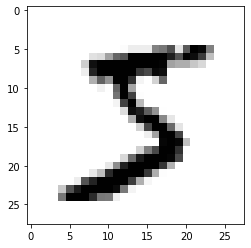

In [3]:
image, label = None, None
for image, label in train_data:
    break

plt.imshow(image.view(28, -1), cmap='gist_yarg')

In [4]:
torch.manual_seed(42)
# Load batches of training and test data sets.
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

[8 1 4 6 3 4 0 2 7 6]


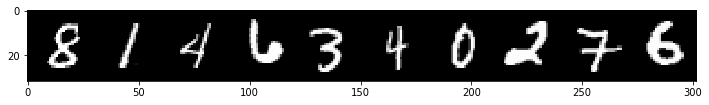

In [5]:
# Show a grid.
for image, label in train_loader:
    break

images = make_grid(image, nrow=10)
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(images.numpy(), axes=(1, 2, 0)))
print("{}".format(label.numpy()))

In [23]:
# Network.
class CCNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
        self.linear = nn.Linear(16 * 5 * 5, 10)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        return F.log_softmax(self.linear(x.view(-1, 16 * 5 * 5)), dim=1)

model = CCNetwork()
print(model)

count = 0
for params in model.parameters():
    count += params.numel()
print(f"Parameters: {count}")

CCNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (linear): Linear(in_features=400, out_features=10, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Parameters: 4950


In [24]:
# Train the model.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 3
losses = []

train_correct = []
train_losses = []

test_correct = []
test_losses = []

for i in range(epoch):
    i += 1
    trn_correct = 0
    tst_correct = 0
    loss = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predictions = torch.max(y_pred, dim=1)[1]
        trn_correct += (predictions == y_train).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 600 == 0:
            print(f'ecpoch: {i}, batch: {b} -> loss -> {loss}')

    train_correct.append(trn_correct)
    train_losses.append(loss)

    with torch.no_grad():

        for X_test, y_test in test_loader:

            y_pred = model(X_test)
            loss = criterion(y_pred, y_test)

            predictions = torch.max(y_pred, dim=1)[1]
            tst_correct += (predictions == y_test).sum()

        test_correct.append(tst_correct)
        test_losses.append(loss)

ecpoch: 1, batch: 600 -> loss -> 0.5022104382514954
ecpoch: 1, batch: 1200 -> loss -> 0.3948657214641571
ecpoch: 1, batch: 1800 -> loss -> 0.19166328012943268
ecpoch: 1, batch: 2400 -> loss -> 0.13003653287887573
ecpoch: 1, batch: 3000 -> loss -> 0.023093903437256813
ecpoch: 1, batch: 3600 -> loss -> 0.056347548961639404
ecpoch: 1, batch: 4200 -> loss -> 0.48476648330688477
ecpoch: 1, batch: 4800 -> loss -> 0.49775147438049316
ecpoch: 1, batch: 5400 -> loss -> 0.06610694527626038
ecpoch: 1, batch: 6000 -> loss -> 0.035062577575445175
ecpoch: 2, batch: 600 -> loss -> 0.0033233806025236845
ecpoch: 2, batch: 1200 -> loss -> 0.3387758731842041
ecpoch: 2, batch: 1800 -> loss -> 0.08270198851823807
ecpoch: 2, batch: 2400 -> loss -> 0.09047270566225052
ecpoch: 2, batch: 3000 -> loss -> 0.0014323112554848194
ecpoch: 2, batch: 3600 -> loss -> 0.030435657128691673
ecpoch: 2, batch: 4200 -> loss -> 0.016525711864233017
ecpoch: 2, batch: 4800 -> loss -> 0.051743991672992706
ecpoch: 2, batch: 5400 

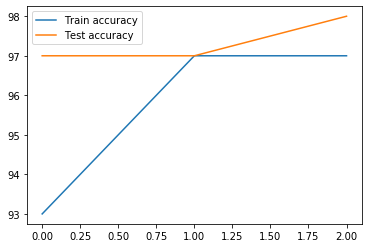

In [26]:
plt.plot([t/600 for t in train_correct], label="Train accuracy")
plt.plot([t/100 for t in test_correct], label="Test accuracy")
plt.legend()

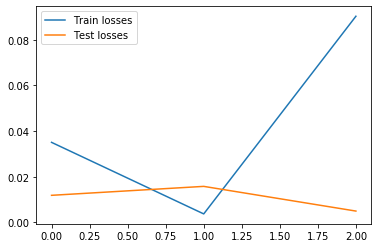

In [27]:
plt.plot(train_losses, label="Train losses")
plt.plot(test_losses, label="Test losses")
plt.legend()

In [43]:
test_all_data = DataLoader(test_data, batch_size=10_000, shuffle=False)
predictions = []
with torch.no_grad():

    for X_test, y_test in test_all_data:

        y_pred = model(X_test)

        predictions = torch.max(y_pred, dim=1)[1]

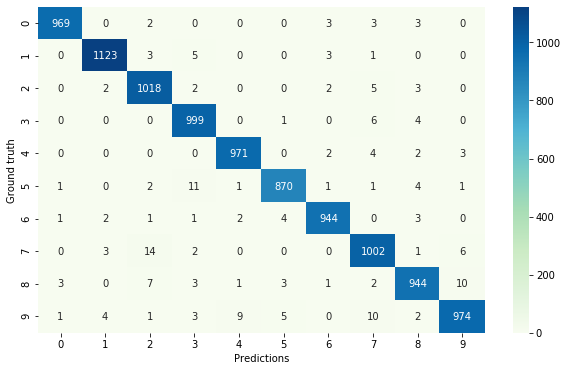

In [63]:
# Confusion matrix.
arr = confusion_matrix(y_test.view(-1), predictions.view(-1))
df = pd.DataFrame(arr, range(10), range(10))
plt.figure(figsize=(10, 6))
sn.heatmap(df, annot=True, cmap='GnBu', fmt='d')
plt.xlabel('Predictions')
plt.ylabel('Ground truth')
plt.show()